# Classification
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository. The goal of this part is to build a machine learning model to predict which playlist the track belongs to. The attempt is stricktly experimental because the assignment is most of the time stricktly subjective, it is susceptible to personal biases and tiny musial nuances. 

There are 29 playlists and XXXX unique songs in the dataset. Some of the songs are assigned to more than one playlist which makes things even harder. Nevertheless, let's give it a try.

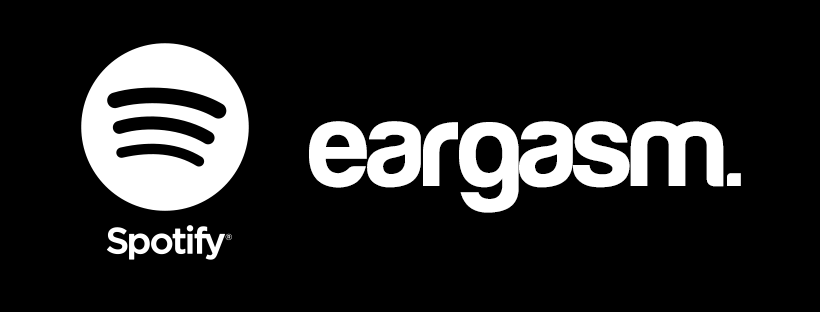

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

eargasm_Classification.ipynb   files	   Untitled0.ipynb
eargasm_DataExploration.ipynb  README.md
eargasm_DataRetrieval.ipynb    test.ipynb


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars
- `timeit` - Measure execution time of small code snippets

In [4]:
from tqdm.notebook import tqdm
import timeit

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [6]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Machine learning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.inspection import partial_dependence, plot_partial_dependence


# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from sklearn.compose import make_column_transformer
# from sklearn.pipeline import make_pipeline



# Feature engineering

# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [8]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


## Select features
Not all features will be useful for model-building therefore I'll drop them. Some features might seem not correct to get rid of so let me explain:
- `track_artist` - due to large number of artists the feature would slow the algorithm down; also, knowing the dataset, it doesn't seem to be a good clue for an algorithm
- `track_populariy` - there's a lot of zeroes in this feature; additionally the mean of the feature is roughly the same regardless of the playlist
- `track_genre` - similarily to `track_artist` there's too many different genres, which would slow down the process; additionally there's a lot of similar tags and it's just doesn't seem to be helpful anyhow
- `mode` - no correlation with the playlists
- `key` - no correlation with the playlists
- `time_signature` - no correlation with the playlists

In [9]:
features_to_keep = [
                    'track_duration',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'tempo',
                    'track_playlist'
                    ]
df_encoded = final_df[features_to_keep]

## Features encoding

In [10]:
def cut_into_categories(feature_name, number_of_categories):

  df_encoded[feature_name] = final_df[feature_name]  
  df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

  ranges = df_encoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

  df_encoded.drop(columns=[feature_name], inplace=True)
  df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

  return df_encoded

In [11]:
def fill_nans(feature_name):
  df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
  return df_encoded

In [12]:
# df_encoded['track_duration'] = final_df['track_duration'] # reset value
# df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

# cut_into_categories('track_duration', 10)
# cut_into_categories('track_popularity', 10)
# cut_into_categories('acousticness', 10)
# cut_into_categories('danceability', 10)
# cut_into_categories('energy', 10)
# cut_into_categories('instrumentalness', 10)
# cut_into_categories('liveness', 10)
# cut_into_categories('speechiness', 10)
# cut_into_categories('valence', 10)
# cut_into_categories('tempo', 15)

# # df_encoded['track_genre'].fillna('unknown', inplace=True)
# df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


# # fill_nans('key')
# # fill_nans('mode')
# # fill_nans('time_signature')

# df_encoded = df_encoded.dropna()
# df_encoded.head()

fill_nans('tempo')
df_encoded.head()

,track_duration,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,track_playlist
0,251266,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,86.502,eargasm | breathe easy
1,254233,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,98.003,eargasm | breathe easy
2,207699,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,85.036,eargasm | breathe easy
3,212640,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,125.088,eargasm | breathe easy
4,274800,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,170.556,eargasm | breathe easy


# Multiclass classification

## Train/test split

In [13]:
X = df_encoded.drop(columns=['track_playlist'])
y = df_encoded['track_playlist']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model selection
Let's use a list of commonly used classifiers and run them with default setting to see how well they perform in terms of accuracy and runtime. After iterating through them, I'll choose three or four best performing ones and try to evaluate them further in order to find a right one.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


list_of_classifiers = [
                       LogisticRegression(),
                       KNeighborsClassifier(),
                       SVC(),
                       DecisionTreeClassifier(),
                       MLPClassifier(),
                       RandomForestClassifier(),
                       AdaBoostClassifier(),
                       GaussianNB(),
                       QuadraticDiscriminantAnalysis(),
                       LinearDiscriminantAnalysis()
                      ]

In [16]:
classifiers = pd.DataFrame()

for classifier in tqdm(list_of_classifiers):
  
  clf = make_pipeline(StandardScaler(), classifier)

  start = timeit.default_timer()
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()

  name = str(classifier).split('(')[0]
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  score_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
  # mean_score = np.mean([train_score, test_score, score_cv])
  runtime = stop-start


  classifiers = classifiers.append(
      {'classifier': name,
       'score_train': train_score,
       'score_test': test_score,
      #  'score_mean': mean_score,
       'score_cv': score_cv,
       'runtime': runtime
      },
      ignore_index = True)

classifiers.sort_values(by='score_cv', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

,classifier,runtime,score_cv,score_test,score_train
0,LogisticRegression,0.583164,0.195948,0.207506,0.216206
9,LinearDiscriminantAnalysis,0.020558,0.195212,0.189845,0.209208
2,SVC,0.472503,0.193002,0.197572,0.289134
4,MLPClassifier,4.545582,0.174954,0.187638,0.292818
7,GaussianNB,0.017283,0.172744,0.173289,0.193738
8,QuadraticDiscriminantAnalysis,0.026319,0.155433,0.173289,0.216943
5,RandomForestClassifier,1.231991,0.130755,0.130243,0.724125
6,AdaBoostClassifier,0.596839,0.123389,0.128035,0.131492
1,KNeighborsClassifier,0.012898,0.123020,0.115894,0.349908
3,DecisionTreeClassifier,0.051692,0.075138,0.080574,0.724125


In [17]:
def model_evaluation(estimator, parameters):
  pipe = make_pipeline(StandardScaler(), estimator)
  parameters = parameters

  search = GridSearchCV(pipe, parameters, n_jobs=-1)
  start = timeit.default_timer()
  search.fit(X_train, y_train)
  stop = timeit.default_timer()

  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_cv = cross_val_score(search, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=train_score,
                            score_train=score_train,
                            score_cv=score_cv
                           )

  return evaluation_results

In [18]:
def confusion_matrix_plot(classifier):
  fig, ax = plt.subplots(figsize=(15, 15))
  plot_confusion_matrix(classifier, X_train, y_train, ax=ax)
  plt.xticks(rotation=90)
  return plt.show()

In [19]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### Logistic Regression

In [20]:
start = timeit.default_timer()

parameters = {
              'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }
evaluation_results = model_evaluation(LogisticRegression(class_weight='balanced', # Cost-Sensitive Logistic Regression
                                                         multi_class='ovr',
                                                         n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



Runtime: 380.342941957 seconds.


In [21]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('logisticregression',
#                   LogisticRegression(C=0.1, class_weight=None, dual=False,
#                                      fit_intercept=True, intercept_scaling=1,
#                                      l1_ratio=None, max_iter=100,
#                                      multi_class='auto', n_jobs=None,
#                                      penalty='l2', random_state=None,
#                                      solver='newton-cg', tol=0.0001, verbose=0,
#                                      warm_start=False))],
#           verbose=False),
#  'b_parameters': {'logisticregression__C': 0.1,
#   'logisticregression__penalty': 'l2',
#   'logisticregression__solver': 'newton-cg'},
#  'b_score': 0.2007366482504604,
#  'runtime': 45.501065313000254,
#  'score_cv': 0.2,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.21804788213627993}

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('logisticregression',
                  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='ovr', n_jobs=-1, penalty='l2',
                                     random_state=None, solver='newton-cg',
                                     tol=0.0001, verbose=0, warm_start=False))],
          verbose=False),
 'b_parameters': {'logisticregression__C': 0.01,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'newton-cg'},
 'b_score': 0.1686924493554328,
 'runtime': 74.41490913799998,
 'score_cv': 0.16574585635359118,
 'score_test': 0.20920810313075505,
 'score_train': 0.17458563535911603}

In [22]:
logreg = evaluation_results['b_estimator']

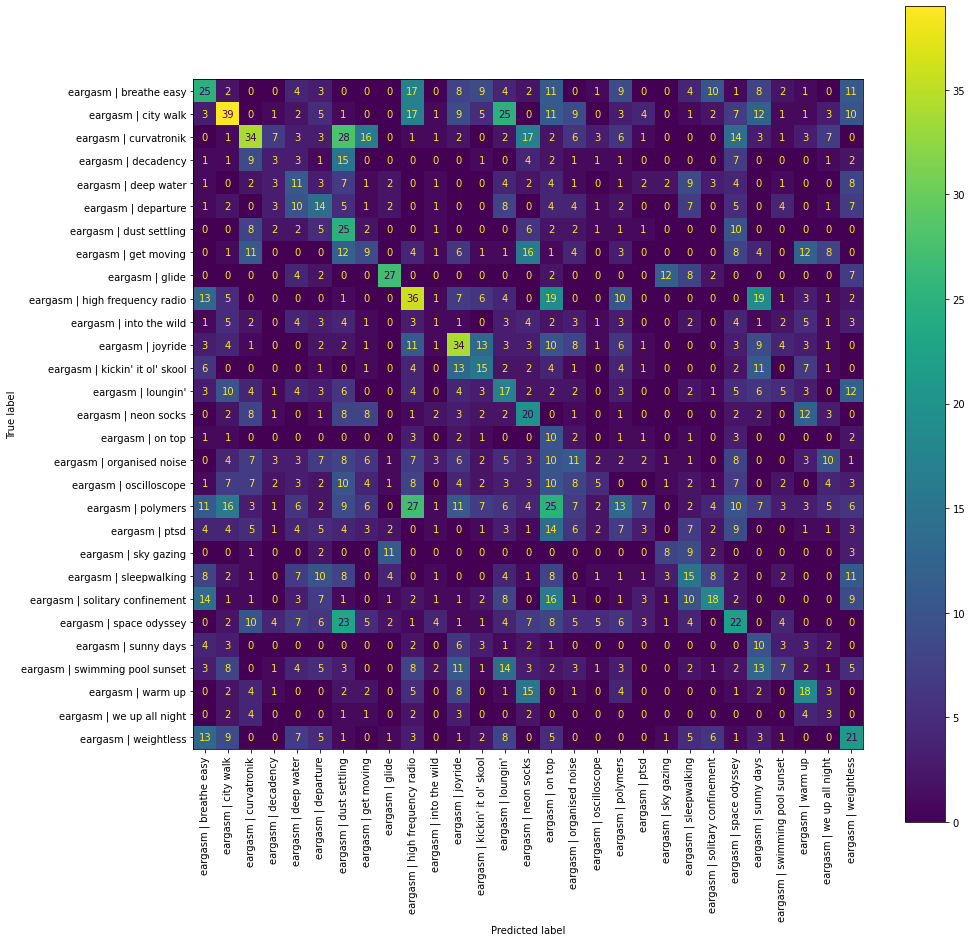

In [23]:
confusion_matrix_plot(logreg)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

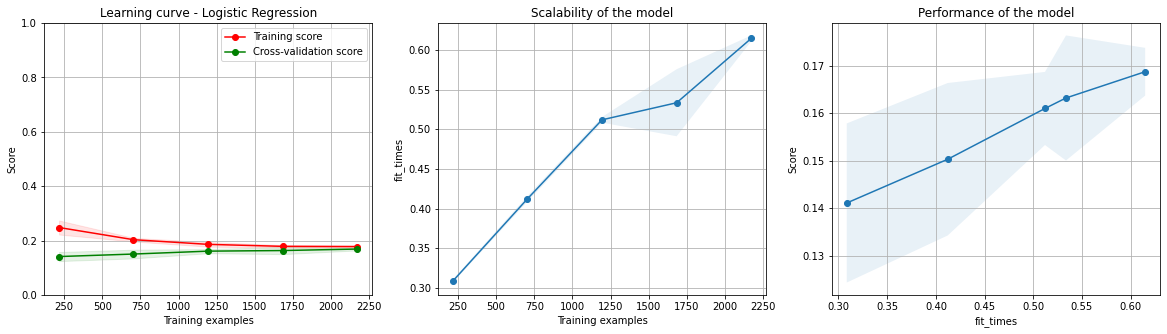

In [24]:
plot_learning_curve(
                    logreg,
                    title='Learning curve - Logistic Regression',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

### Linear Discriminant Analysis

In [25]:
start = timeit.default_timer()

parameters = {
              'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],
              'lineardiscriminantanalysis__shrinkage': [None, 'auto']
             }
evaluation_results = model_evaluation(LinearDiscriminantAnalysis(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 3.35226860399996 seconds.


In [26]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('lineardiscriminantanalysis',
#                   LinearDiscriminantAnalysis(n_components=None, priors=None,
#                                              shrinkage=None, solver='svd',
#                                              store_covariance=False,
#                                              tol=0.0001))],
#           verbose=False),
#  'b_parameters': {'lineardiscriminantanalysis__shrinkage': None,
#   'lineardiscriminantanalysis__solver': 'svd'},
#  'b_score': 0.19521178637200737,
#  'runtime': 0.5912703990006776,
#  'score_cv': 0.19152854511970535,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.20920810313075505}

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('lineardiscriminantanalysis',
                  LinearDiscriminantAnalysis(n_components=None, priors=None,
                                             shrinkage=None, solver='svd',
                                             store_covariance=False,
                                             tol=0.0001))],
          verbose=False),
 'b_parameters': {'lineardiscriminantanalysis__shrinkage': None,
  'lineardiscriminantanalysis__solver': 'svd'},
 'b_score': 0.19521178637200737,
 'runtime': 0.5980363190000162,
 'score_cv': 0.19152854511970535,
 'score_test': 0.20920810313075505,
 'score_train': 0.20920810313075505}

In [27]:
lda = evaluation_results['b_estimator']

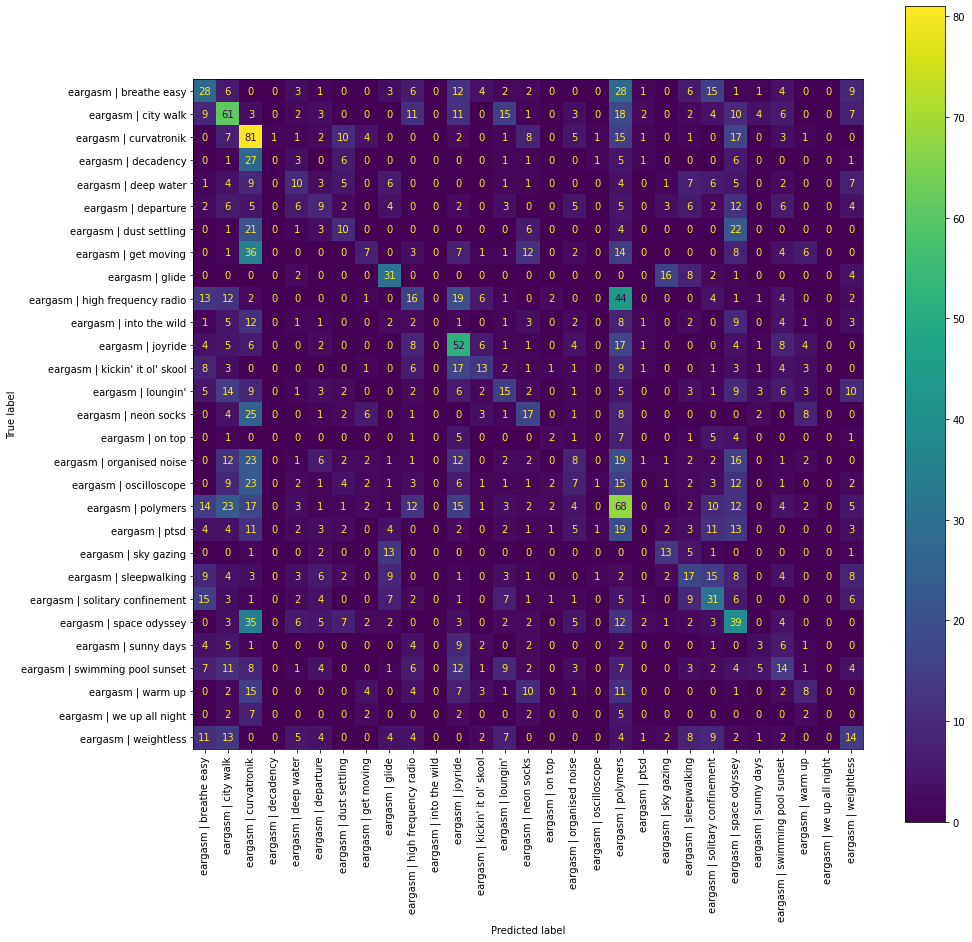

In [28]:
confusion_matrix_plot(lda)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

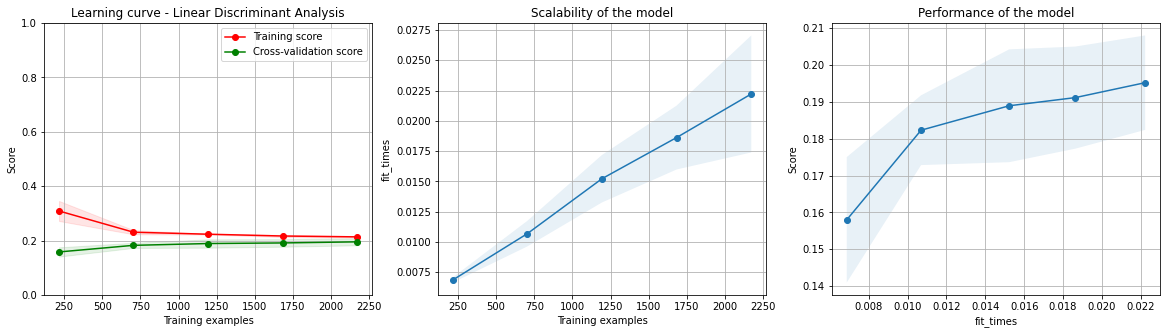

In [29]:
plot_learning_curve(
                    lda,
                    title='Learning curve - Linear Discriminant Analysis',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

In [30]:
coefficients = pd.DataFrame(lda.named_steps['lineardiscriminantanalysis'].coef_)
playlist_names = df_encoded['track_playlist'].unique()
feature_names = X.columns
coefficients.set_index(playlist_names, inplace=True)
coefficients.columns = X.columns

# fig = px.imshow(coefficients,
#                 width=1000,
#                 height=1000,
#                 title='Feature importance',
#                 )
# fig.show()

figure = go.Heatmap(
                    z=coefficients,
                    x=feature_names,
                    y=playlist_names,
                    colorscale='Viridis',
                    # zmax=1,
                    # zmin=-1,
                    # zmid=0
                   )                      

layout = go.Layout(
                   title=go.layout.Title(text="Correlation heatmap", x=0.5),
                   width=860,
                   height=860
                  )

fig = go.Figure(
                data=figure,
                layout=layout
               )
fig.show()


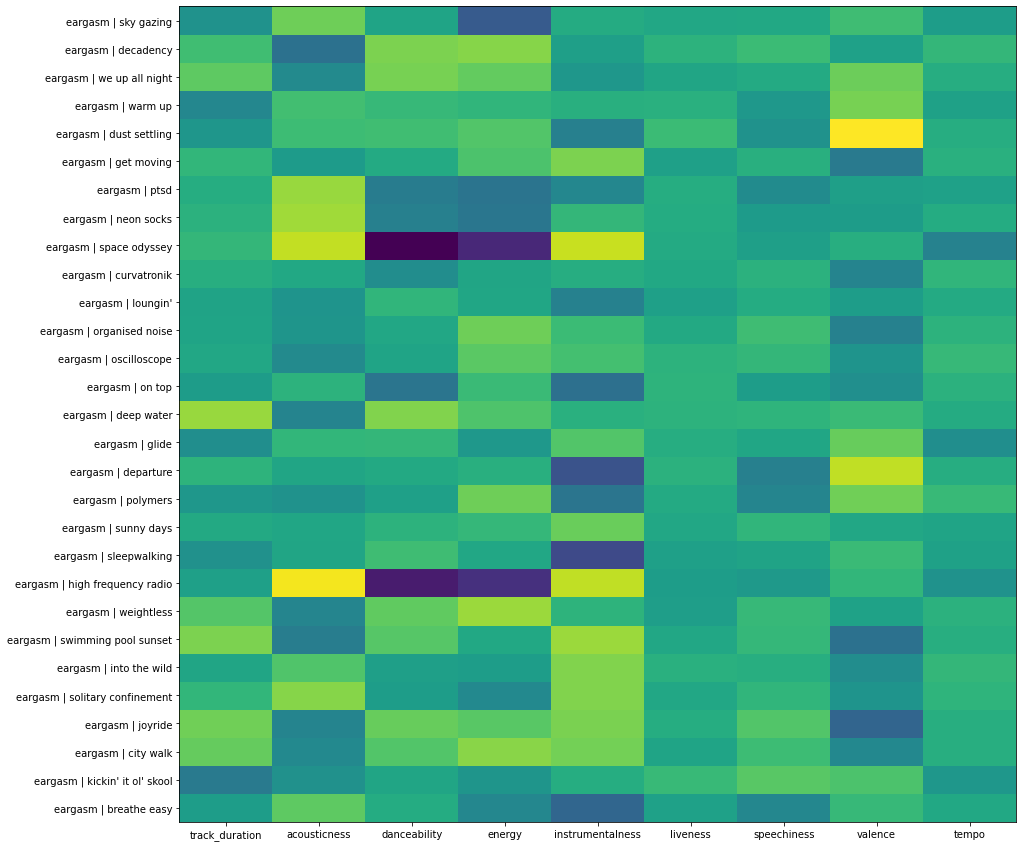

In [31]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
fig, ax = plt.subplots(figsize=(15, 15))
plt.pcolor(coefficients)
plt.yticks(np.arange(0.5, len(coefficients.index), 1), coefficients.index)
plt.xticks(np.arange(0.5, len(coefficients.columns), 1), coefficients.columns)
plt.show()

In [32]:
coefficients

,track_duration,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo
eargasm | breathe easy,-0.210762,0.600362,0.044897,-0.568610,-1.127571,-0.141720,-0.568528,0.262777,-0.016618
eargasm | kickin' it ol' skool,-0.789458,-0.407789,-0.069505,-0.343038,0.063685,0.284492,0.552661,0.456609,-0.308730
eargasm | city walk,0.649683,-0.541982,0.509898,0.887988,0.741872,-0.086756,0.327764,-0.553819,0.087968
eargasm | joyride,0.730324,-0.627100,0.654306,0.546428,0.795786,0.058739,0.497245,-1.137094,0.095315
eargasm | solitary confinement,0.216027,0.873420,-0.212759,-0.548760,0.834216,-0.037647,0.207360,-0.351416,0.191650
eargasm | into the wild,-0.062192,0.490659,-0.179062,-0.207427,0.841038,0.128446,0.098420,-0.478983,0.234494
eargasm | swimming pool sunset,0.797731,-0.743483,0.536397,-0.014770,0.987011,-0.032719,0.246151,-0.941790,0.086158
eargasm | weightless,0.516906,-0.603695,0.620184,0.988090,0.170213,-0.189414,0.263202,-0.109733,0.145390
eargasm | high frequency radio,-0.161059,1.538916,-2.142622,-1.896446,1.211320,-0.205650,-0.277416,0.218152,-0.380046
eargasm | sleepwalking,-0.419147,-0.059519,0.343576,-0.036531,-1.543856,-0.158521,-0.099494,0.299774,-0.131175


### Support Vector Classifier

In [33]:
start = timeit.default_timer()

parameters = {
              'svc__C': [1, 3, 6],
              'svc__kernel': ['linear', 'poly', 'rbf'],
              # 'svc__degree': [1, 2, 3]
             }
evaluation_results = model_evaluation(SVC(probability=True, decision_function_shape='ovo'), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 322.7018014800001 seconds.


In [34]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('svc',
#                   SVC(C=6, break_ties=False, cache_size=200, class_weight=None,
#                       coef0=0.0, decision_function_shape='ovo', degree=1,
#                       gamma='scale', kernel='poly', max_iter=-1,
#                       probability=False, random_state=None, shrinking=True,
#                       tol=0.001, verbose=False))],
#           verbose=False),
#  'b_parameters': {'svc__C': 6,
#   'svc__decision_function_shape': 'ovo',
#   'svc__degree': 1,
#   'svc__kernel': 'poly'},
#  'b_score': 0.19594843462246775,
#  'runtime': 100.24534427800063,
#  'score_cv': 0.1911602209944751,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.2151012891344383}

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovo', degree=3,
                      gamma='scale', kernel='linear', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'b_parameters': {'svc__C': 1, 'svc__kernel': 'linear'},
 'b_score': 0.19300184162062614,
 'runtime': 71.05481962299996,
 'score_cv': 0.19042357274401472,
 'score_test': 0.20920810313075505,
 'score_train': 0.2154696132596685}

In [35]:
svc = evaluation_results['b_estimator']

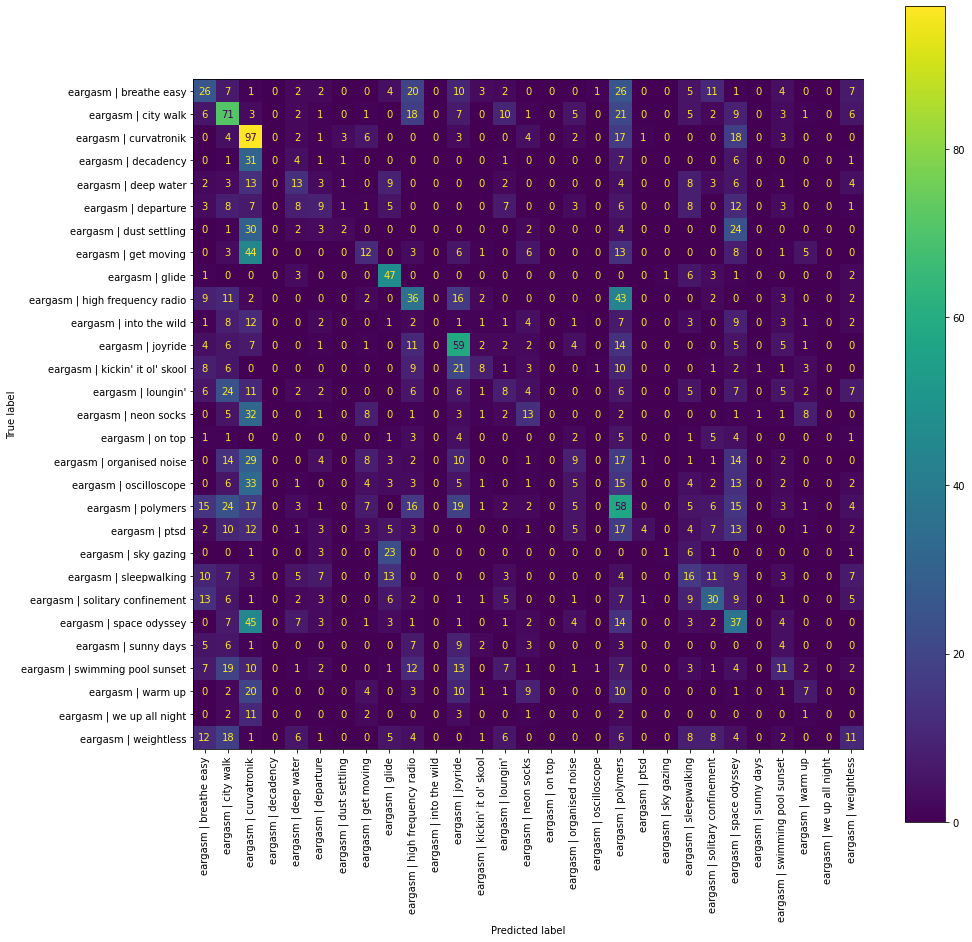

In [36]:
confusion_matrix_plot(svc)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

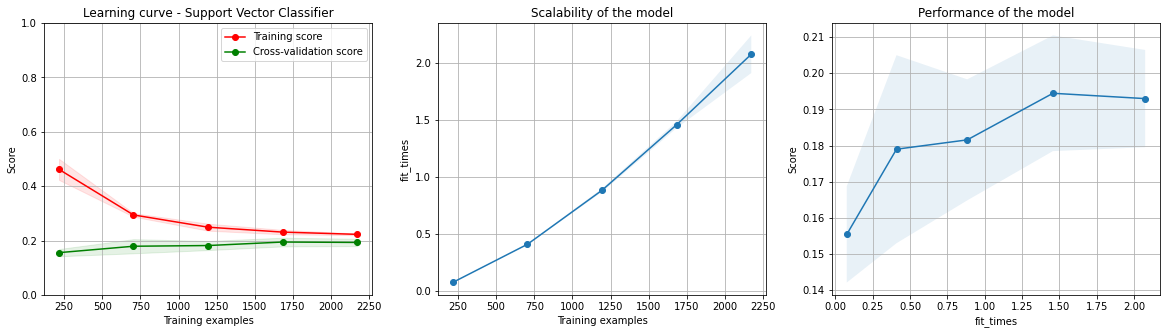

In [37]:
plot_learning_curve(
                    svc,
                    title='Learning curve - Support Vector Classifier',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

### Random Forest Classifier

In [38]:
start = timeit.default_timer()

parameters = {
              'randomforestclassifier__n_estimators': [1000],
              'randomforestclassifier__max_depth': [5],
              'randomforestclassifier__min_samples_leaf': [1,2,3]
             }
evaluation_results = model_evaluation(RandomForestClassifier(class_weight='balanced'), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 296.3080847200001 seconds.


In [39]:
evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight='balanced',
                                         criterion='gini', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=3, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=1000, n_jobs=None,
                                         oob_score=False, random_state=None,
                

In [40]:
evaluation_results

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight='balanced',
                                         criterion='gini', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=3, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=1000, n_jobs=None,
                                         oob_score=False, random_state=None,
                

In [41]:
rfc = evaluation_results['b_estimator']

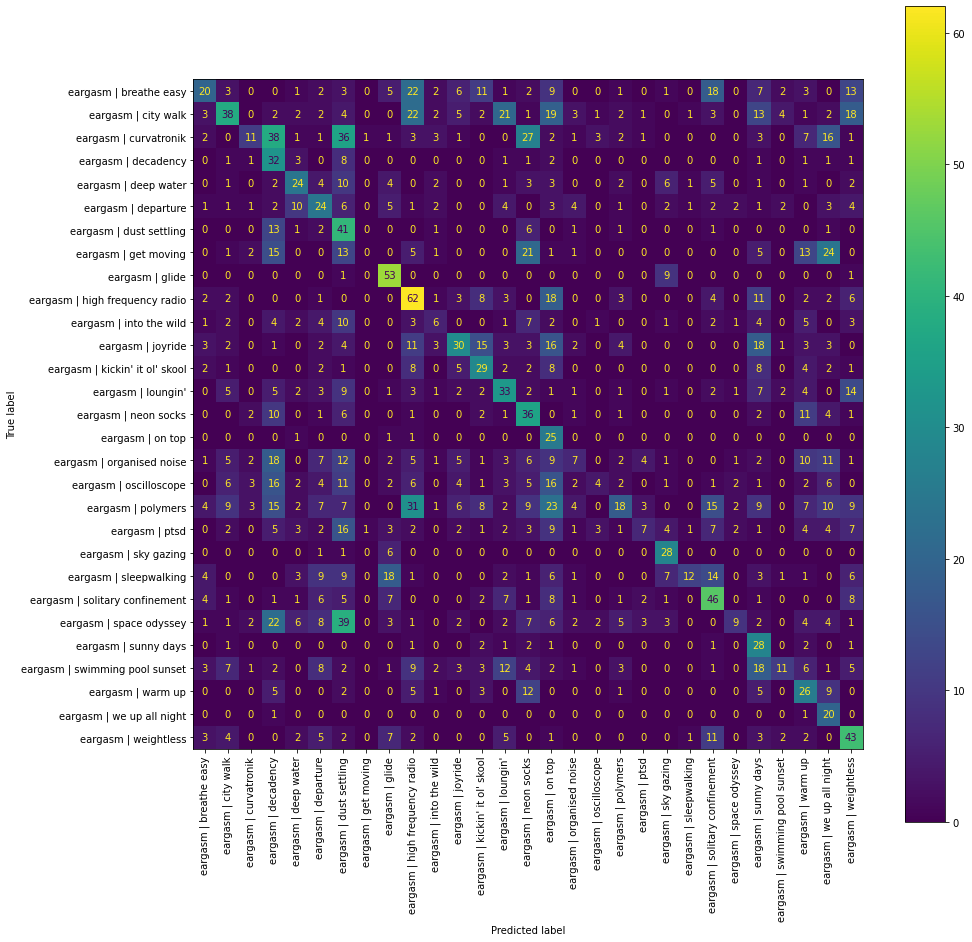

In [42]:
confusion_matrix_plot(rfc)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

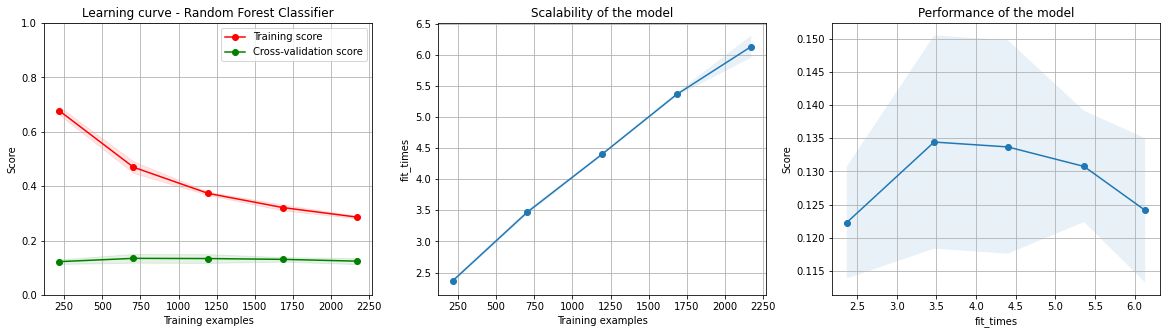

In [43]:
plot_learning_curve(
                    rfc,
                    title='Learning curve - Random Forest Classifier',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

## Probability check

In [44]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)

  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']

  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth:\n{}'.format(prediction, df, truth))

In [45]:
clf = svc
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

Prediction: 
 ('eargasm | space odyssey', 'https://open.spotify.com/track/3NfRKsjVfCBtL3oTzmA8cj')

 Probabilities: 
                       class  probability
23  eargasm | space odyssey     0.125802
5       eargasm | departure     0.088590
17   eargasm | oscilloscope     0.077900

 Truth:
2917     eargasm | oscilloscope
2918    eargasm | space odyssey
Name: track_playlist, dtype: object


In [46]:
dfghdfgjdfj

NameError: ignored

### Random Forest Classifier

`RandomForestClassifier()` had the best `mean_score` of all estimators but looks like it's overfitting the data. It also ran significantly longer than most of the others but let's evalue it further. 

https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [ ]:
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier())
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

In [ ]:
pipe = make_pipeline(StandardScaler(), SVC())
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

In [ ]:
start = timeit.default_timer()

parameters = {
              'n_estimators': [10, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [3, 4, 5, 6],
              'max_features': [2, 3, 4]
             }

evaluation_results = model_evaluation(RandomForestClassifier(n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
evaluation_results

In [ ]:
rfc = evaluation_results['b_estimator']

In [ ]:
asdfasdgasdga asdf

### Decision Tree Classifier

`DecisionTreeClassifier()` received `mean_score` similar to `RandomForestClassifier()` and overfits similarily. However, the algorithm seems to be a lot faster, so let's give it a try.

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [ ]:
from sklearn import svm

clf = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

## Multilabel classification
https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value/45088911

In [ ]:
# columns = final_df.columns.to_list()
# columns.remove('track_playlist')

columns = [
           'track_id',
           'track_url',
           'acousticness',
           'danceability',
           'instrumentalness',
           'valence',
           'tempo',
           'track_duration',
           'track_popularity',
           'track_playlist'
          ]

# df_nodup = final_df.copy()
df = final_df.copy()[columns]

df = df.groupby(['track_id', 'track_url', 'acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']).agg(list).reset_index()
df.head()



In [ ]:
X = df.drop(columns=['track_id', 'track_playlist', 'track_url'])
y = df['track_playlist']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

# y_converted = mlb.fit_transform(y)
# y_converted
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
# # cross_val_score(clf, X_test, y_test, cv=10).mean()


In [ ]:
y_pred = pd.Series(mlb.inverse_transform(clf.predict(X_test)))
y_pred[530]


In [ ]:
X_test.iloc[520]

In [ ]:
index_number = X_test.index[520]
index_number

In [ ]:
df.loc[index_number]['track_url']

In [ ]:
def check_multilabel(number):
  # index_number = X_test.index[590]
  # pl_names = y_test.columns
  # mask = clf.predict(X_test)[590].astype(bool)
  # id = df.loc[index_number]['track_id']
  # preds = pl_names[mask]
  # url = final_df.loc[final_df['track_id'] == '7pHujzt4Naoo4czUgxBQyr']['track_url']
  return print(preds, url)

In [ ]:
check_multilabel(590)

## Multi output

In [ ]:
X = df_encoded[['acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']]
y = df_encoded['track_playlist']

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
# mlb.classes_

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# Y_train = mlb.fit_transform(y_train)
# Y_test = mlb.fit_transform(y_test)
# Y_train[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.predict_proba(X_test)

## Shit

In [ ]:
# X = df_encoded.drop('track_playlist', axis='columns')
# y = df_encoded['track_playlist']

In [ ]:
# ordinal_categories = [
#                       'track_duration',
#                       'track_popularity',
#                       'acousticness',
#                       'danceability',
#                       'energy',
#                       'instrumentalness',
#                       'liveness',
#                       'speechiness',
#                       'valence',
#                       'tempo'
#                      ]

# nominal_categories = [
#                       'track_genre',
#                       'key',
#                       'mode',
#                       'time_signature'
#                      ]
# column_transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), nominal_categories),
#     remainder='passthrough'
#     )
# column_transformer.fit_transform(X)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()

In [ ]:
# pipe = make_pipeline(column_transformer, knn)

In [ ]:
# cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(X_encoded[['track_genre']]).shape
# ohe.categories_
# # pe = OrdinalEncoder()



In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification
- https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4